In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="0"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax, flax, optax
import jax.numpy as jnp
from flax.linen.module import Module, compact
from flax.linen.initializers import zeros_init, normal, xavier_normal
from jax import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
print(jax.extend.backend.get_backend().platform)

gpu


In [3]:
class LowRankQUBO(Module):
    Rank: int
    
    @compact
    def __call__(me, x):
        Bs, Ch = x.shape
        Rank = me.Rank
        V = me.param('V', xavier_normal(), (Ch,Rank), jnp.float32)
        b = me.param('b', zeros_init(), (Ch,), jnp.float32)
        a = me.param('a', zeros_init(), (1,), jnp.float32)
        W = jnp.matmul( V, V.T) # Ch x Ch

        a_batch = a.reshape(1)
        b_batch = b.reshape(1,Ch)
        W_batch = W.reshape(1,Ch,Ch)
        
        xij_batch = x.reshape(Bs,1,Ch) * x.reshape(Bs,Ch,1)

        res = a_batch + (b_batch*x).sum(axis=1) + (xij_batch * W_batch).sum(axis=(1,2))
        return res

78.64320000000001
0.0


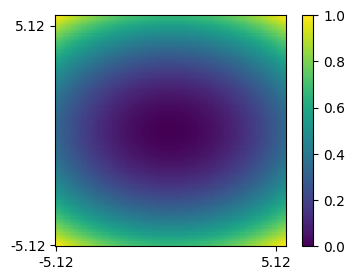

(10201,) 10201


In [4]:
R = 2
BpR = 101

xl = np.linspace(-5.12,5.12,BpR)
yl = np.linspace(-5.12,5.12,BpR)
x,y = np.meshgrid(xl,yl)
z = x**2 + y**2 * 2
print (np.max(z))
z = z / np.max(z)
print ( np.min(z) )

plt.figure(figsize=(4,3))
plt.imshow(z, origin="lower", interpolation='none')
plt.xticks([0,96],[xl[0],xl[BpR-1]])
plt.yticks([0,96],[yl[0],yl[BpR-1]])
plt.colorbar()
plt.show()

t_all = z.flatten()
print (t_all.shape, BpR**R)

In [5]:
from functools import lru_cache
#@lru_cache(maxsize = None)
def get_loss(pid):
    return t_all[pid]

def get_sample(pid): #dim=R, range=(0,BpR-1)
    ovec = [(pid//BpR)%BpR,(pid)%BpR] ###############
    xvec = np.zeros([R,BpR] , dtype=np.float32)
    for i, o in enumerate(ovec):
        xvec[i,o] = 1.
    ans = get_loss( pid )
    return xvec.flatten(), ans

x_li = []
for i in range(BpR**R):
    x,t = get_sample(i)
    x_li.append(x)
x_all = np.array(x_li)

In [6]:
def learn_FMQA(dataset_x, dataset_t, SRcoef, L2coef):

    def loss(params, x, t):
        y = model.apply(params, x)
        L1 = ((t-y)**2).sum()
    
        V = params['params']['V']
        Vpk = V.reshape(R,BpR,-1) #  i, pi, rank
        B = params['params']['b']
        Bpk = B.reshape(R,BpR)
    
        Vpk_d = jnp.square(Vpk[:,1:,:] - Vpk[:,:-1,:])
        Bpk_d = jnp.square(Bpk[:,1:] - Bpk[:,:-1])
        SR = jnp.sum(Vpk_d) + jnp.sum(Bpk_d)

        V2d = jnp.square(Vpk[:,:,:])
        B2d = jnp.square(Bpk[:,:])
        L2 = jnp.sum(V2d) + jnp.sum(B2d)
        return L1 + SRcoef*SR + L2coef*L2 

    loss_grad_fn = jax.value_and_grad(loss)
    
    model = LowRankQUBO(Rank = 64)
    Ch = R*BpR
    key1, key2 = random.split(random.PRNGKey(173))
    x = random.normal(key1, (7,Ch))
    params = model.init(key2, x)
    
    tx = optax.amsgrad(learning_rate=1e-1)
    opt_state = tx.init(params)
    
    loss_li = []
    l2_li = []
    
    for loop in range(500):
        x, t = np.array(dataset_x), np.array(dataset_t)
        loss_val, grads = loss_grad_fn(params, x, t)
        updates, opt_state = tx.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        loss_li.append( np.array(loss_val) )
    
    
        V = np.array(params['params']['V'])
        Vpk = V.reshape(R,BpR,-1)
        Vpk_d = np.square(Vpk[:,1:,:] - Vpk[:,:-1,:])
        l2_li.append( np.sum(Vpk_d) )
    
        print (end="#", flush = True) if loop%100 == 0 else None
    #plt.figure(figsize=(4,2))
    #plt.semilogy(loss_li)
    return model, params
def get_allpoint(model, params):
    SP_SIZE = len(x_all)/1024
    sets = np.array_split(x_all, SP_SIZE, 0)
    y_sets = []
    for b, x_sp in enumerate(sets):
        y_sp = np.array(model.apply(params, np.array(x_sp)))
        y_sets.append(y_sp)
        print (end="?") if b%100 == 0 else None
    y_li = np.concatenate(y_sets)
    return np.array(y_li)

In [7]:
def BoltzmanSample(yli):
    beta = 20.
    prob = np.exp(-beta*yli)
    prob /= np.sum(prob)
    cump = np.cumsum(prob)

    pid_list = []
    for i in range(16):
        p = np.random.rand()
        pid = np.sum(cump < p)
        #print (pid, yli[pid])
        pid_list.append(pid)
    return pid_list

## SRcoef : Strength of FSR, L2coef : Strength of L2 regularization.
1) SRcoef = 0.0, L2coef = 0.0 : Set No Regularizatoin. The model will estimate highly noisy Hamiltonian. 
2) SRcoef = 0.0, L2coef = 1.0 : Set L2 Regularizatoin. The model will still estimate noisy Hamiltonian. 
3) SRcoef = 1.0, L2coef = 0.0 : Set FSR (our proposed method). The model will estimate Hamiltonians that are consistent with the true Hamiltonian.

In [8]:
dataset_x = []
dataset_t = []
add_list = []
plot_x1 = []
plot_x2 = []
ymap_li = []
np.random.seed(421)

pid_list = np.random.randint(BpR**R, size=(16,) )
for i in range(17):
    for pid in pid_list:
        add_list.append(pid)
        xvec, t = get_sample(pid)
        dataset_x.append(xvec)
        dataset_t.append(t)
        ovec = np.argmax(xvec.reshape(R,BpR),axis=1)
        plot_x1.append( ovec[0] )
        plot_x2.append( ovec[1] )
    
    model, params = learn_FMQA(dataset_x, dataset_t, SRcoef=0.0, L2coef=0.0) ## Set Regularization
    yli = get_allpoint(model, params)
    ymap_li.append(yli)
    pid_list = BoltzmanSample(yli)
    print ( list(pid_list) )
    del model, params
    
    print (f"step({len(dataset_t):04d})", f"{pid:05d}", "L=", t_all[pid] )

result_set_2 = (np.array(plot_x1), np.array(plot_x2), np.array(ymap_li), np.array(dataset_t) )

#####?[3665, 3377, 3069, 3402, 3377, 3069, 3665, 3059, 3069, 3377, 3402, 3402, 3402, 3069, 3069, 3059]
step(0016) 03363 L= 0.13040000000000002
#####?[3351, 3351, 3351, 7412, 3351, 2049, 3421, 3351, 3421, 3755, 3351, 3362, 3351, 2049, 3351, 3756]
step(0032) 03059 L= 0.16546666666666662
#####?[2050, 2050, 2050, 2059, 2059, 2050, 2059, 3354, 2059, 2050, 2059, 3833, 2059, 2050, 2059, 2050]
step(0048) 03756 L= 0.17320000000000002
#####?[3372, 3781, 1352, 3372, 3340, 3372, 1352, 3776, 3781, 3781, 3776, 3372, 3367, 3372, 3372, 3781]
step(0064) 02050 L= 0.2933333333333333
#####?[2038, 3429, 3429, 3429, 3429, 3429, 3429, 3393, 3352, 3429, 3429, 3429, 2037, 2038, 3429, 3429]
step(0080) 03781 L= 0.049866666666666656
#####?[3373, 3389, 3365, 1948, 3370, 3411, 3335, 3335, 2064, 3385, 3373, 2040, 3396, 3335, 3392, 1948]
step(0096) 03429 L= 0.3592000000000001
#####?[3368, 3346, 3337, 3422, 3364, 3399, 3346, 3382, 3428, 3409, 3346, 3422, 3382, 3368, 3409, 3399]
step(0112) 01948 L= 0.3150666666666667
#

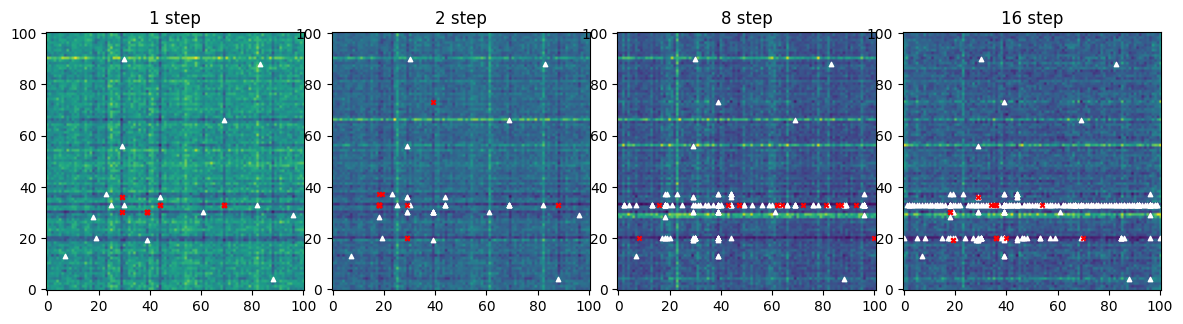

In [9]:
plt.figure(figsize=(3*4,3*2))
sc = 0

for ri, result_set in enumerate([result_set_2]):
    plot_x1, plot_x2, ymap_li, dataset_t = result_set
    for step in [1,2, 8, 16]:
        sc += 1
        yli = ymap_li[step-1]
        plt.subplot(2,4, sc)
        plt.imshow( yli.reshape(BpR,BpR), origin="lower" )
        plt.scatter( plot_x2[:(step)*16], plot_x1[:(step)*16], marker="^", s=10, c="w")
        plt.scatter( plot_x2[(step)*16:(step+1)*16], plot_x1[(step)*16:(step+1)*16], marker="x", s=10, c="r")
        plt.title(f"{step} step") if ri==0 else None
plt.tight_layout(w_pad=-2)
plt.show()

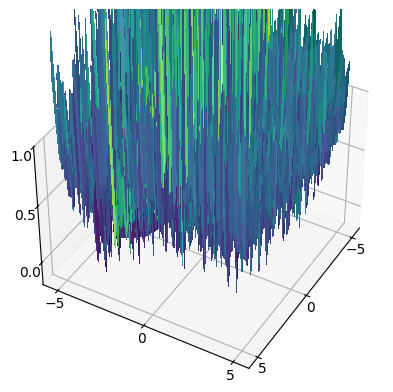

In [10]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
import numpy as np

x,y = np.meshgrid(xl,yl)

fig, axs = plt.subplots(1,1, figsize=(4,4), subplot_kw=dict(projection='3d', computed_zorder=False))
axs = [axs]
ls = LightSource(270, 45)

for figid in range(1):
    if figid == 0:
        plot_x1, plot_x2, ymap_li, dataset_t = result_set_2
        z = ymap_li[16].reshape(BpR,BpR)

    
    rgb = ls.shade(z, cmap=cm.viridis, vert_exag=0.1, blend_mode='soft')
    surf = axs[figid].plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=False, shade=False, edgecolor='none')
    axs[figid].view_init(40,30)
    axs[figid].set_xticks([-5,0,5])
    axs[figid].set_yticks([-5,0,5])
    axs[figid].set_zticks([0,.5,1.])
    axs[figid].set_zlim(-.2,1)
    axs[figid].tick_params(axis='x', which='major', pad=-5)
    axs[figid].tick_params(axis='y', which='major', pad=-5)
    axs[figid].tick_params(axis='z', which='major', pad=-3)

    if figid > 0:
        axs[figid].scatter3D(xl[plot_x2[:16*(16)]], yl[plot_x1[:16*(16)]], dataset_t[:16*(16)], marker=".",c="w", s=1, zorder=1000, alpha=0.2)
    
    
plt.tight_layout()
plt.show()